In [50]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md
from matplotlib import ticker
from scipy import stats

#sns.set(rc={'figure.figsize':(8,4), 'figure.autolayout': True})
sns.set(rc={'figure.figsize':(8,3.5), 'figure.autolayout': True})
sns.set_style("whitegrid")
data_path = '../datasets/titan_rur/'

In [2]:
dfs = []
for i in range(2015, 2020):
    dfs.append(pd.read_csv(os.path.join(data_path, 'RUR', f'{i}.csv')))

df = pd.concat(dfs)

from dateutil.parser import parse
df['start_time'] = df.start_time.apply(parse)
df['end_time'] = df.end_time.apply(parse)
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()

In [3]:
# Calculate nodehours

df['nodehours'] = df['duration'] * df['node_count'] / 60.0 / 60.0

In [4]:
# find GPU jobs and their statistics
data = []

# weekly sampling - plotting
for group_name, df_group in df.resample('W-Mon', on='start_time'):
  
    gpu_jobs = df_group[(df_group['gpu_pids'] > 0) & (df_group['alps_exit'] == 0)].shape[0]
    all_jobs = df_group[(df_group['alps_exit'] == 0)].shape[0]

    gpu_nodehours = df_group[(df_group['gpu_pids'] > 0) & (df_group['alps_exit'] == 0)]['nodehours'].sum()
    all_nodehours = df_group[(df_group['alps_exit'] == 0)]['nodehours'].sum()
    
    gpu_time = df_group[(df_group['gpu_pids'] > 0) & (df_group['alps_exit'] == 0)]['duration'].sum()
    all_time = df_group[(df_group['alps_exit'] == 0)]['duration'].sum()
    
    #print(group_name, all_time)
    #print(df_group)
 
    if all_time > 0:
        data.append([
            group_name,
            gpu_jobs, all_jobs, gpu_jobs / all_jobs * 100,
            gpu_nodehours, all_nodehours, gpu_nodehours / all_nodehours * 100,
            gpu_time, all_time, gpu_time / all_time * 100
        ])
 
columns = [
    'date',
    'gpu_jobs', 'all_jobs', 'gpu_jobs_fraction',
    'gpu_nodehours', 'all_nodehours', 'gpu_nodehours_fraction',
    'gpu_time', 'all_time', 'gpu_time_fraction'
]
processed = pd.DataFrame(data, columns=columns)


In [5]:

# statistics - without sampling

gpu_jobs = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)].shape[0]
all_jobs = df[(df['alps_exit'] == 0)].shape[0]

print(f"GPU Jobs {gpu_jobs}, all jobs {all_jobs}, fraction {gpu_jobs/all_jobs*100}%")

gpu_time = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)]['nodehours'].sum()
all_time = df[(df['alps_exit'] == 0)]['nodehours'].sum()

print(f"GPU Nodehours {gpu_time}, all jobs {all_time}, fraction {gpu_time/all_time*100}%")

gpu_time = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)]['duration'].sum()
all_time = df[(df['alps_exit'] == 0)]['duration'].sum()

print(f"GPU Duration {gpu_time}, all jobs {all_time}, fraction {gpu_time/all_time*100}%")


GPU Jobs 2619770, all jobs 11313720, fraction 23.15569061281347%
GPU Nodehours 308405896.03870773, all jobs 562470322.4330144, fraction 54.830607720718696%
GPU Duration 7757796961.539122, all jobs 13579177542.247623, fraction 57.130094495068015%


/home/mcopik/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mcopik/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


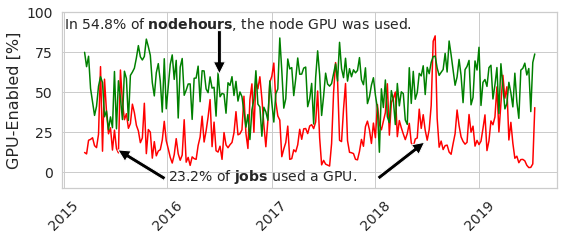

In [52]:
fig, ax1 = plt.subplots()

sns.lineplot('date', 'gpu_jobs_fraction', color='red', data=processed, ax=ax1)
#sns.lineplot('date', 'gpu_time_fraction', color='blue', data=processed, ax=ax1)
plot = sns.lineplot('date', 'gpu_nodehours_fraction', color='green', data=processed, ax=ax1)

ax1.set_xlabel('')#'',fontsize=16)
ax1.set_ylabel('GPU-Enabled [%]',fontsize=16)
#plt.set_title('Piz Daint, data from 31.03 to 7.04 in 2021.', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=14)
ax1.tick_params(axis='y', labelsize=14)


#xfmt = md.DateFormatter('%Y-%m')
xfmt = md.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(xfmt)
ticks = [np.datetime64(f'{year}') for year in range(2015, 2020)]
ax1.xaxis.set_ticks(ticks)

ax1.set_ylim([-10,100])
ax1.yaxis.set_ticks([0, 25, 50, 75, 100])#, labels=[0, 25, 50, 75, 100])


plot.annotate(r'In 54.8% of $\bf{nodehours}$, the node GPU was used.',
             xy=(np.datetime64('2016-01-21 16:44:16'), 75),  #xycoords='data',
            xytext=(np.datetime64('2015-01-01 16:44:16'), 90), fontsize=14,
)
plot.annotate(
    "",
    xy=(np.datetime64('2016-07-01 16:44:16'), 60),
    xytext=(np.datetime64('2016-07-01 16:44:16'), 90),
    fontsize=16,
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plot.annotate(r'23.2% of $\bf{jobs}$ used a GPU.',
             xy=(np.datetime64('2016-01-21 16:44:16'), -0),  #xycoords='data',
            xytext=(np.datetime64('2016-01-01 16:44:16'), -5), fontsize=14,
    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)
plot.annotate(
    "",
    xy=(np.datetime64('2015-07-01 16:44:16'), 15),
    xytext=(np.datetime64('2016-01-01 16:44:16'), -5),
    fontsize=16,
    arrowprops=dict(facecolor='black', shrink=0.05)
)
plot.annotate(
    "",
    xy=(np.datetime64('2018-07-01 16:44:16'), 20),
    xytext=(np.datetime64('2018-01-01 16:44:16'), -5),
    fontsize=14,
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plot.figure.savefig(os.path.join('plots', "gpu_utilization_titan.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False, dpi=1200)


In [82]:

# statistics - without sampling

gpu_jobs = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)].shape[0]
all_jobs = df[(df['alps_exit'] == 0)].shape[0]

print(f"GPU Jobs {gpu_jobs}, all jobs {all_jobs}, fraction {gpu_jobs/all_jobs*100}%")

gpu_time = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)]['nodehours'].sum()
all_time = df[(df['alps_exit'] == 0)]['nodehours'].sum()

print(f"GPU Nodehours {gpu_time}, all jobs {all_time}, fraction {gpu_time/all_time*100}%")

gpu_time = df[(df['gpu_pids'] > 0) & (df['alps_exit'] == 0)]['duration'].sum()
all_time = df[(df['alps_exit'] == 0)]['duration'].sum()

print(f"GPU Duration {gpu_time}, all jobs {all_time}, fraction {gpu_time/all_time*100}%")


GPU Jobs 2619770, all jobs 11313720, fraction 23.15569061281347%
GPU Nodehours 308405896.03870773, all jobs 562470322.4330144, fraction 54.830607720718696%
GPU Duration 7757796961.539122, all jobs 13579177542.247623, fraction 57.130094495068015%
